In [24]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import torchvision
from torchsummary import summary
from torchvision.models import densenet121,DenseNet121_Weights
import torchvision.models as models

In [4]:
dataset_path = '/kaggle/input/pets-facial-expression-dataset/Master Folder'

In [3]:
def calculate_mean_std(dataset_path, batch_size=32):
    # Add resizing to ensure consistent image dimensions
    transform = transforms.Compose([
        transforms.Resize((224, 224)), 
        transforms.ToTensor()
    ])
    
    dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    total_sum = torch.zeros(3)
    total_squared_sum = torch.zeros(3)
    total_count = 0
    
    for inputs, _ in loader:
        # Flatten image batch 
        inputs = inputs.view(inputs.size(0), inputs.size(1), -1)
        total_sum += inputs.sum(dim=(0, 2))
        total_squared_sum += (inputs ** 2).sum(dim=(0, 2))
        total_count += inputs.size(0) * inputs.size(2)  
    

    mean = total_sum / total_count
    std = torch.sqrt((total_squared_sum / total_count) - (mean ** 2))
    
    return mean.tolist(), std.tolist()

 
mean, std = calculate_mean_std(os.path.join(dataset_path, 'train'))
print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: [0.5000774264335632, 0.4557059407234192, 0.4074406027793884]
Std: [0.27882811427116394, 0.267927885055542, 0.27114740014076233]


In [5]:
mean = [0.5000774264335632, 0.4557059407234192, 0.4074406027793884]
std = [0.27882811427116394, 0.267927885055542, 0.27114740014076233]

In [6]:
train_transform = transforms.Compose([
    transforms.Resize(224),   
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
'''
test_transform = transforms.Compose([
    transforms.Resize(320),  
    
    transforms.TenCrop(size=299),  
    transforms.Lambda(lambda crops: torch.stack([
        transforms.Normalize(mean, std)(transforms.ToTensor()(crop)) for crop in crops
    ]))
])
'''
test_transform = transforms.Compose([
    transforms.Resize(224),  
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [7]:
train_data = datasets.ImageFolder(os.path.join(dataset_path, 'train'), transform = train_transform)
test_data = datasets.ImageFolder(os.path.join(dataset_path, 'test'), transform = test_transform)
val_data = datasets.ImageFolder(os.path.join(dataset_path, 'valid'), transform = test_transform)
train_loader = DataLoader(train_data,
                          batch_size= 64, shuffle= True, pin_memory= False)
test_loader = DataLoader(test_data,
                         batch_size= 64, shuffle= False, pin_memory= False)
val_loader = DataLoader(val_data,
                         batch_size= 64, shuffle= False, pin_memory= False)
classes = ['Angry','Sad','happy','Other']
class_names = train_data.classes
print(class_names)
print(f'Number of train images: {len(train_data)}')
print(f'Number of test images: {len(test_data)}')
print(f'Number of validation images: {len(val_data)}')
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Available processor {}".format(device))

['Angry', 'Other', 'Sad', 'happy']
Number of train images: 1000
Number of test images: 38
Number of validation images: 36
Available processor cuda


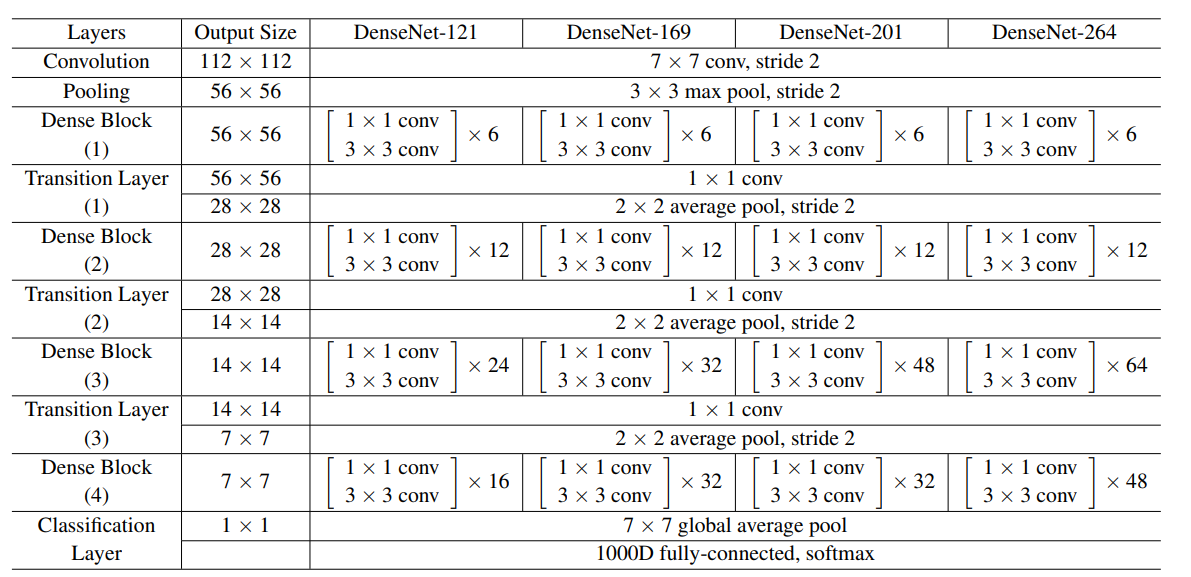

In [8]:
k = 32

In [9]:
class DenseLayer(nn.Module):

    def __init__(self,in_channels):
        super(DenseLayer,self).__init__()

        self.BN1 = nn.BatchNorm2d(num_features = in_channels)
        self.conv1 = nn.Conv2d( in_channels=in_channels , out_channels=4*k , kernel_size=1 , stride=1 , padding=0 , bias = False )

        self.BN2 = nn.BatchNorm2d(num_features = 4*k)
        self.conv2 = nn.Conv2d( in_channels=4*k , out_channels=k , kernel_size=3 , stride=1 , padding=1 , bias = False )

        self.relu = nn.ReLU()

    def forward(self,x):
        xin = x
        x = self.BN1(x)
        x = self.relu(x)
        x = self.conv1(x)

        x = self.BN2(x)
        x = self.relu(x)
        x = self.conv2(x)

        x = torch.cat([xin,x],1)

        return x

In [10]:
class DenseBlock(nn.Module):
    def __init__(self,layer_num,in_channels):
        super(DenseBlock,self).__init__()
        self.layer_num = layer_num
        self.deep_nn = nn.ModuleList()

        for num in range(self.layer_num):
            self.deep_nn.add_module(f"DenseLayer_{num}",DenseLayer(in_channels+k*num))


    def forward(self,x):
        xin = x
        for layer in self.deep_nn:
            x = layer(x)
        return x

In [11]:
class TransitionLayer(nn.Module):
    def __init__(self,in_channels,compression_factor):

        super(TransitionLayer,self).__init__()
        self.BN = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels = in_channels , out_channels = int(in_channels*compression_factor) ,kernel_size = 1 ,stride = 1 ,padding = 0, bias=False )
        self.avgpool = nn.AvgPool2d(kernel_size = 2, stride = 2)

    def forward(self,x):
        x = self.BN(x)
        x = self.conv1(x)
        x = self.avgpool(x)
        return x

In [12]:
class DenseNet(nn.Module):
    def __init__(self,param_list,in_channels,num_classes=4):
        super(DenseNet,self).__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels ,out_channels=64 ,kernel_size=7 ,stride=2 ,padding=3 ,bias = False)
        self.BN1 = nn.BatchNorm2d(num_features=64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.deep_nn = nn.ModuleList()
        dense_block_inchannels = 64

        for num in range(len(param_list))[:-1]:

            self.deep_nn.add_module( f"DenseBlock_{num+1}" , DenseBlock( param_list[num] , dense_block_inchannels ) )
            dense_block_inchannels  = int(dense_block_inchannels + k*param_list[num])

            self.deep_nn.add_module( f"TransitionLayer_{num+1}" , TransitionLayer( dense_block_inchannels,0.5 ) )
            dense_block_inchannels = int(dense_block_inchannels*0.5)

        self.deep_nn.add_module( f"DenseBlock_{num+2}" , DenseBlock( param_list[-1] , dense_block_inchannels ) )
        dense_block_inchannels  = int(dense_block_inchannels + k*param_list[-1])

        self.BN2 = nn.BatchNorm2d(num_features=dense_block_inchannels)

        self.average_pool = nn.AdaptiveAvgPool2d(1)
        
        
        self.fc1 = nn.Linear(dense_block_inchannels, num_classes)


    def forward(self,x):
        x = self.relu(self.BN1(self.conv1(x)))
        x = self.maxpool(x)
        
        for layer in self.deep_nn:
            x = layer(x)
            
        x = self.relu(self.BN2(x))
        x = self.average_pool(x)

        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)

        return x
model_parameters= [6,12,24,16]
model = DenseNet(model_parameters,3)

In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device,learning_rate):
    model = model.to(device)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        if epoch % 3 == 0:
            learning_rate = learning_rate / 10
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        val_accuracy = 100 * correct_val / total_val
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")


    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
    plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train vs Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()


In [14]:
def evaluate_model(model, test_loader, num_classes):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.cuda(), labels.cuda()  # Use GPU if available
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))
    
    cm = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Plot Confusion Matrix as Heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

Epoch [1/10], Train Loss: 1.3962, Validation Loss: 1.3737, Train Accuracy: 30.20%, Validation Accuracy: 25.00%
Epoch [2/10], Train Loss: 1.3210, Validation Loss: 1.3095, Train Accuracy: 35.20%, Validation Accuracy: 30.56%
Epoch [3/10], Train Loss: 1.3031, Validation Loss: 1.4555, Train Accuracy: 38.20%, Validation Accuracy: 27.78%
Epoch [4/10], Train Loss: 1.3001, Validation Loss: 1.3927, Train Accuracy: 39.00%, Validation Accuracy: 27.78%
Epoch [5/10], Train Loss: 1.2533, Validation Loss: 1.5190, Train Accuracy: 42.90%, Validation Accuracy: 36.11%
Epoch [6/10], Train Loss: 1.2529, Validation Loss: 1.4683, Train Accuracy: 40.70%, Validation Accuracy: 30.56%
Epoch [7/10], Train Loss: 1.2413, Validation Loss: 1.4609, Train Accuracy: 41.90%, Validation Accuracy: 30.56%
Epoch [8/10], Train Loss: 1.2080, Validation Loss: 1.8225, Train Accuracy: 45.40%, Validation Accuracy: 41.67%
Epoch [9/10], Train Loss: 1.1901, Validation Loss: 1.2668, Train Accuracy: 46.60%, Validation Accuracy: 38.89%
E

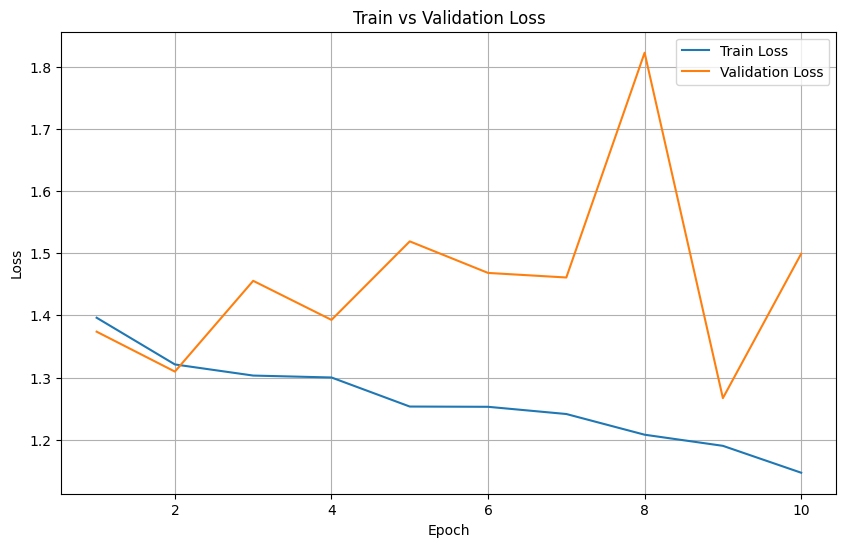

In [15]:
num_epochs = 10
learning_rate = 0.0001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model = model.to(device)
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device,learning_rate)

Test Accuracy: 31.58%

Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.40      0.31        10
           1       0.25      0.17      0.20         6
           2       0.43      0.27      0.33        11
           3       0.36      0.36      0.36        11

    accuracy                           0.32        38
   macro avg       0.32      0.30      0.30        38
weighted avg       0.33      0.32      0.31        38


Confusion Matrix:
[[4 1 3 2]
 [3 1 0 2]
 [4 1 3 3]
 [5 1 1 4]]


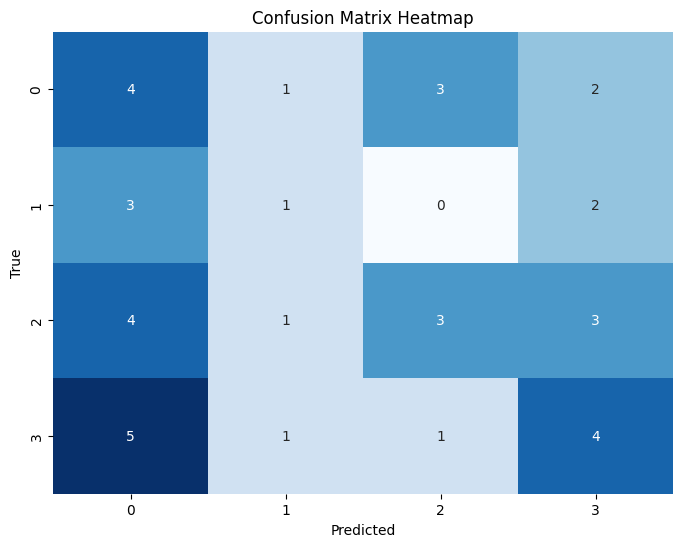

In [16]:
evaluate_model(model, test_loader,4)

In [17]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
       BatchNorm2d-5           [-1, 64, 56, 56]             128
              ReLU-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]           8,192
       BatchNorm2d-8          [-1, 128, 56, 56]             256
              ReLU-9          [-1, 128, 56, 56]               0
           Conv2d-10           [-1, 32, 56, 56]          36,864
       DenseLayer-11           [-1, 96, 56, 56]               0
      BatchNorm2d-12           [-1, 96, 56, 56]             192
             ReLU-13           [-1, 96, 56, 56]               0
           Conv2d-14          [-1, 128,

In [18]:
torchvision_model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
architecture = 'torchvision_model'
total_params = sum(p.numel() for p in torchvision_model.parameters())
print(total_params)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 86.1MB/s]


7978856


In [19]:
model_parameters= [6,12,24,16]
custom_model = DenseNet(model_parameters,3)

In [20]:
def transfer_weights(pretrained_model, custom_model):
    pretrained_layers = [layer for layer in pretrained_model.modules() if isinstance(layer, (nn.Conv2d, nn.BatchNorm2d, nn.Linear))]
    custom_layers = [layer for layer in custom_model.modules() if isinstance(layer, (nn.Conv2d, nn.BatchNorm2d, nn.Linear))]

    for pretrained_layer, custom_layer in zip(pretrained_layers, custom_layers):
        # Check same type and shape
        if isinstance(pretrained_layer, type(custom_layer)) and pretrained_layer.weight.size() == custom_layer.weight.size():
            custom_layer.weight.data.copy_(pretrained_layer.weight.data)
            if hasattr(pretrained_layer, 'bias') and hasattr(custom_layer, 'bias'):
                if pretrained_layer.bias is not None and custom_layer.bias is not None:
                    custom_layer.bias.data.copy_(pretrained_layer.bias.data)
        else:
            print(f"Skipping incompatible layers: {pretrained_layer} -> {custom_layer}")


transfer_weights(torchvision_model, custom_model)

print("Weights transferred successfully!")

Skipping incompatible layers: Linear(in_features=1024, out_features=1000, bias=True) -> Linear(in_features=1024, out_features=4, bias=True)
Weights transferred successfully!


In [25]:
model = models.densenet121(pretrained=True)

num_classes = 4
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Train Loss: 1.3979, Validation Loss: 1.5061, Train Accuracy: 28.40%, Validation Accuracy: 16.67%
Epoch [2/10], Train Loss: 1.3506, Validation Loss: 1.4540, Train Accuracy: 34.20%, Validation Accuracy: 22.22%
Epoch [3/10], Train Loss: 1.2676, Validation Loss: 1.4194, Train Accuracy: 40.00%, Validation Accuracy: 25.00%
Epoch [4/10], Train Loss: 1.2028, Validation Loss: 1.3825, Train Accuracy: 49.20%, Validation Accuracy: 33.33%
Epoch [5/10], Train Loss: 1.1520, Validation Loss: 1.3639, Train Accuracy: 55.50%, Validation Accuracy: 36.11%
Epoch [6/10], Train Loss: 1.0946, Validation Loss: 1.3435, Train Accuracy: 59.30%, Validation Accuracy: 38.89%
Epoch [7/10], Train Loss: 1.0529, Validation Loss: 1.3305, Train Accuracy: 63.10%, Validation Accuracy: 41.67%
Epoch [8/10], Train Loss: 1.0140, Validation Loss: 1.3207, Train Accuracy: 63.90%, Validation Accuracy: 38.89%
Epoch [9/10], Train Loss: 0.9759, Validation Loss: 1.2972, Train Accuracy: 68.40%, Validation Accuracy: 47.22%
E

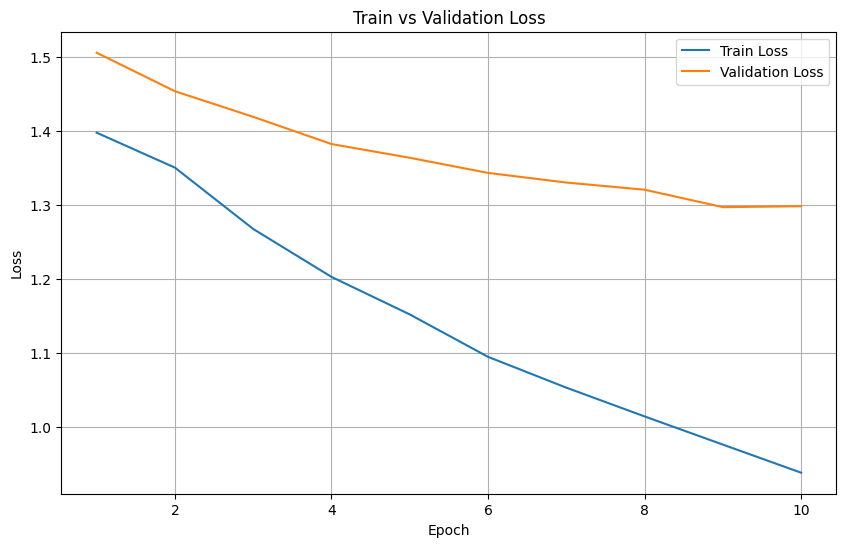

In [27]:
num_epochs = 10
learning_rate = 0.00001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model = model.to(device)
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device,learning_rate)

Test Accuracy: 47.37%

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.80      0.59        10
           1       0.20      0.17      0.18         6
           2       0.62      0.45      0.53        11
           3       0.50      0.36      0.42        11

    accuracy                           0.47        38
   macro avg       0.45      0.45      0.43        38
weighted avg       0.48      0.47      0.46        38


Confusion Matrix:
[[8 1 1 0]
 [4 1 0 1]
 [2 1 5 3]
 [3 2 2 4]]


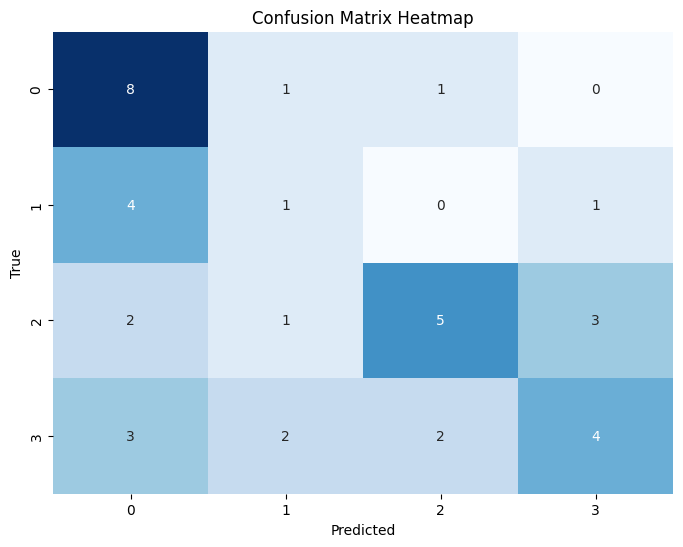

In [29]:
evaluate_model(model, test_loader,4)